In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pizza_df = pd.read_excel('dataset/master/Pizza_Sale.xlsx')
ingred_df = pd.read_excel('dataset/master/Pizza_ingredients.xlsx')

In [3]:
pizza_df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [4]:
pizza_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [5]:
def desc_na(data):
    total=data.isnull().sum().sort_values(ascending=False)
    percent=(data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [6]:
desc_na(pizza_df)

,Total,Percent
pizza_category,23,0.047306
pizza_name_id,16,0.032908
pizza_ingredients,13,0.026738
total_price,7,0.014397
pizza_name,7,0.014397
pizza_id,0,0.000000
order_id,0,0.000000
quantity,0,0.000000
order_date,0,0.000000
order_time,0,0.000000


In [7]:
pizza_df.dropna(inplace=True)

## Parse Date

In [8]:
def parse_dates(date):
  for fmt in ('%d-%m-%Y', '%d/%m/%Y'):
    try:
      return pd.to_datetime(date, format=fmt)
    except ValueError:
      pass
  raise ValueError(f'no valid date format found for {date}')

In [9]:
pizza_df['order_date'] = pizza_df['order_date'].apply(parse_dates)

In [10]:
pizza_df['order_date'].head()

0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
4   2015-01-01
Name: order_date, dtype: datetime64[ns]

## Group by order date

In [11]:
quantity_over_time = pizza_df.groupby('order_date')['quantity'].sum()

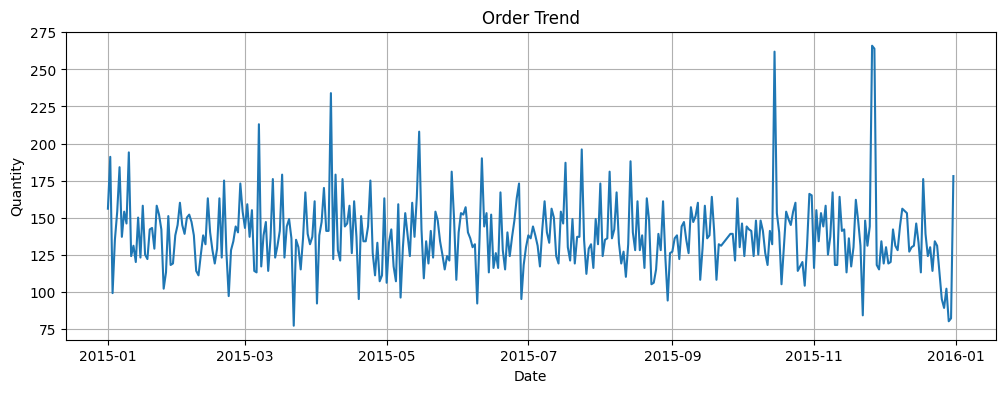

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(quantity_over_time.index, quantity_over_time.values)
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Order Trend')
plt.grid(True)
plt.show()

## Stationary Test

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
# H0: it is not stationary
# H1: it is stationary

def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [15]:
check_stationarity(quantity_over_time)

The series is stationary


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
eval_data = pizza_df.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack().fillna(0)

In [18]:
eval_data.head()

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,6.0,5.0,...,4.0,4.0,0.0,7.0,5.0,2.0,5.0,2.0,7.0,3.0
2015-01-02,12.0,9.0,3.0,7.0,15.0,3.0,2.0,13.0,5.0,6.0,...,6.0,5.0,3.0,9.0,9.0,5.0,3.0,4.0,8.0,1.0
2015-01-03,2.0,3.0,1.0,1.0,6.0,0.0,1.0,4.0,5.0,4.0,...,1.0,2.0,0.0,9.0,4.0,3.0,0.0,5.0,4.0,6.0
2015-01-04,2.0,3.0,0.0,2.0,3.0,3.0,2.0,8.0,7.0,6.0,...,4.0,8.0,6.0,10.0,4.0,4.0,6.0,1.0,3.0,5.0
2015-01-05,6.0,1.0,1.0,4.0,11.0,2.0,5.0,9.0,6.0,4.0,...,5.0,5.0,0.0,6.0,5.0,2.0,4.0,5.0,10.0,6.0


In [19]:
one_pizza = eval_data['The Barbecue Chicken Pizza']

In [20]:
# split train and test
train = one_pizza[:-7]
test = one_pizza[-7:]

In [21]:
# Fit Arima model
ari_model = ARIMA(train, order=(1, 1, 0))
ari_result = ari_model.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
# forecast
ari_forecast = ari_result.get_forecast(steps=len(test))
ari_fore_values = ari_forecast.predicted_mean

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [23]:
ari_predict = ari_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [24]:
ari_predict.index = test.index

In [25]:
concatenated_series = pd.concat([test, ari_predict], axis=1)
concatenated_series.columns = ['Actual', 'Predicted']
concatenated_series

,Actual,Predicted
order_date,,
2015-12-24,4.0,5.084266
2015-12-26,5.0,5.503550
2015-12-27,4.0,5.311574
2015-12-28,2.0,5.399474
2015-12-29,4.0,5.359227
2015-12-30,6.0,5.377655
2015-12-31,10.0,5.369217


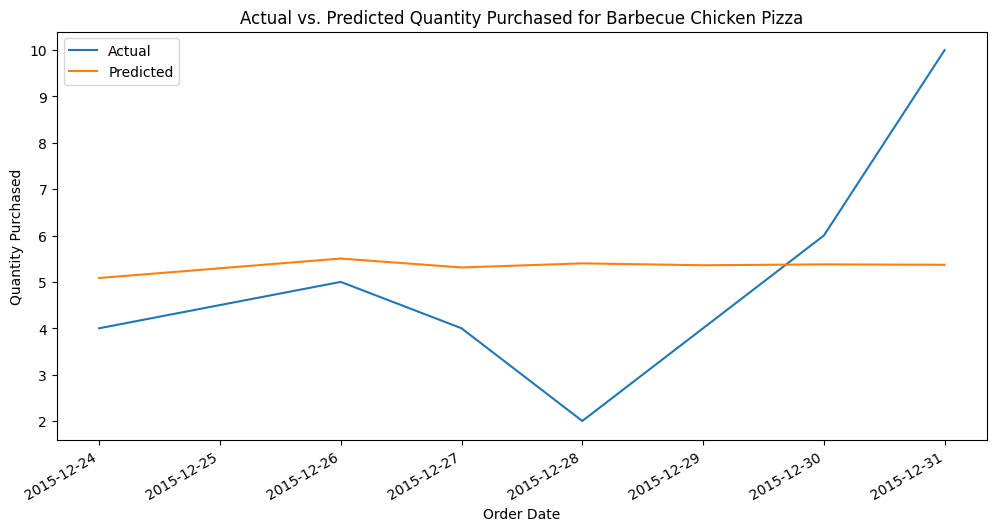

In [26]:
concatenated_series.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Purchased')
plt.title('Actual vs. Predicted Quantity Purchased for Barbecue Chicken Pizza')
plt.show()

In [27]:
# Evaluate the model
mae = mean_absolute_error(test, ari_fore_values)
mse = mean_squared_error(test, ari_fore_values)
rmse = np.sqrt(mse)

print(f'ARIMA MAE: {mae}')
print(f'ARIMA MSE: {mse}')
print(f'ARIMA RMSE: {rmse}')

ARIMA MAE: 1.844459820206821
ARIMA MSE: 5.483543168447492
ARIMA RMSE: 2.3416966431302524


In [28]:
# fit SARIMA model
sari_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sari_result = sari_model.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68177D+00    |proj g|=  7.28031D-02


 This problem is unconstrained.



At iterate    5    f=  2.46590D+00    |proj g|=  1.79135D-02

At iterate   10    f=  2.45033D+00    |proj g|=  9.21384D-03

At iterate   15    f=  2.44880D+00    |proj g|=  1.89396D-03

At iterate   20    f=  2.44869D+00    |proj g|=  7.77467D-04

At iterate   25    f=  2.44868D+00    |proj g|=  1.42990D-04

At iterate   30    f=  2.44867D+00    |proj g|=  2.72418D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35      1     0     0   2.724D-05   2.449D+00
  F =   2.4486742555183776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [29]:
# sarima forecast
sari_forecast = sari_result.get_forecast(steps=len(test))
sari_fore_values = sari_forecast.predicted_mean

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [30]:
# Evaluate Sarima
mae = mean_absolute_error(test, sari_fore_values)
mse = mean_squared_error(test, sari_fore_values)
rmse = np.sqrt(mse)

print(f'SARIMAX MAE: {mae}')
print(f'SARIMAX MSE: {mse}')
print(f'SARIMAX RMSE: {rmse}')

SARIMAX MAE: 2.4496222653825606
SARIMAX MSE: 7.643850443489737
SARIMAX RMSE: 2.764751425262267


In [31]:
sari_predict = sari_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [32]:
sari_predict.index = test.index

In [33]:
sari_predict

order_date
2015-12-24    7.520049
2015-12-26    6.311610
2015-12-27    5.876285
2015-12-28    6.495931
2015-12-29    6.131542
2015-12-30    6.517961
2015-12-31    6.706022
Name: predicted_mean, dtype: float64

In [34]:
concatenated_sarima = pd.concat([test, sari_predict] , axis=1)
concatenated_sarima.columns = ['Actual', 'Predicted']
concatenated_sarima

,Actual,Predicted
order_date,,
2015-12-24,4.0,7.520049
2015-12-26,5.0,6.311610
2015-12-27,4.0,5.876285
2015-12-28,2.0,6.495931
2015-12-29,4.0,6.131542
2015-12-30,6.0,6.517961
2015-12-31,10.0,6.706022


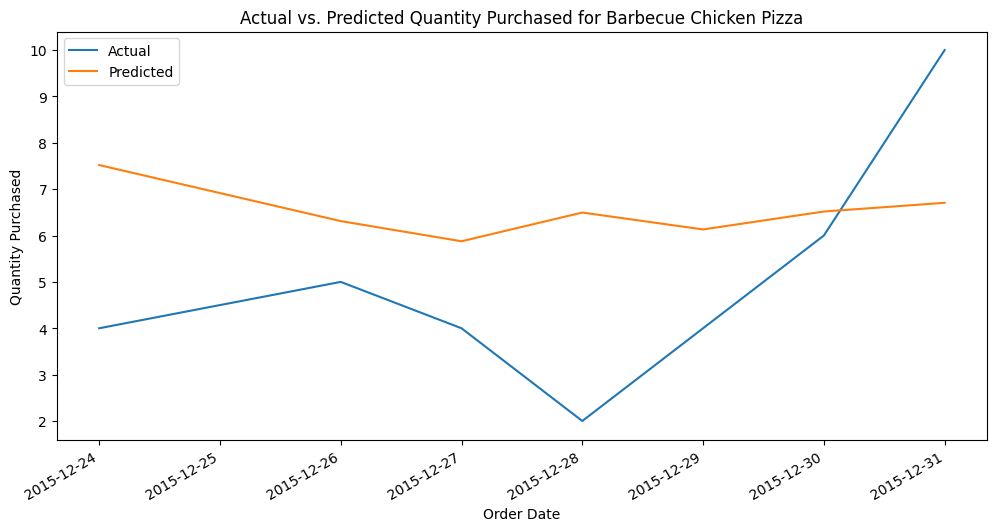

In [35]:
concatenated_sarima.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Purchased')
plt.title('Actual vs. Predicted Quantity Purchased for Barbecue Chicken Pizza')
plt.show()